<a href="https://colab.research.google.com/github/MohmedAAK/NLP-alg.-comparison/blob/main/lstm_%2Bglove_for_disaster_tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import necessary libraries

In [ ]:
!git clone https://github.com/nikjohn7/Disaster-Tweets-Kaggle

Cloning into 'Disaster-Tweets-Kaggle'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), done.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve
import re
import string
import tqdm
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
lemma = WordNetLemmatizer()
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization,SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


### Load data

In [ ]:
train= pd.read_csv('/content/Disaster-Tweets-Kaggle/data/train.csv')
test=pd.read_csv('/content/Disaster-Tweets-Kaggle/data/test.csv')
submission = pd.read_csv("/content/Disaster-Tweets-Kaggle/data/sample_submission.csv")

In [ ]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [ ]:
missing_val = pd.DataFrame(train.isnull().sum())
missing_val = missing_val.reset_index()
missing_val

,index,0
0,id,0
1,keyword,61
2,location,2533
3,text,0
4,target,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,7613.0,5441.934848,3137.11609,1.0,2734.0,5408.0,8146.0,10873.0
target,7613.0,0.429660,0.49506,0.0,0.0,0.0,1.0,1.0


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

### Data cleaning and preprocessing

Before doing the data analysis, it would be better if we could clean-up our data to remove html tags, emojis and other punctuations

In [ ]:
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

train['clean_text'] = train['text'].apply(lambda x: remove_URL(x))
train['clean_text'] = train['clean_text'].apply(lambda x: remove_emoji(x))
train['clean_text'] = train['clean_text'].apply(lambda x: remove_html(x))
train['clean_text'] = train['clean_text'].apply(lambda x: remove_punct(x))

In [ ]:
# Tokenizing the cleaned texts.

train['tokenized'] = train['clean_text'].apply(word_tokenize)


In [ ]:
train.head()

,id,keyword,location,text,target,clean_text,tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala..."


In [ ]:
train['lower'] = train['tokenized'].apply(
    lambda x: [word.lower() for word in x])

train['no_stopwords'] = train['lower'].apply(
    lambda x: [word for word in x if word not in set(nltk.corpus.stopwords.words('english'))])



In [ ]:
train['no_stopwords'] = [' '.join(map(str, l)) for l in train['no_stopwords']]

In [ ]:
train.head()

,id,keyword,location,text,target,clean_text,tokenized,lower,no_stopwords
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this earthquake Ma...,"[Our, Deeds, are, the, Reason, of, this, earth...","[our, deeds, are, the, reason, of, this, earth...",deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask Canada,"[Forest, fire, near, La, Ronge, Sask, Canada]","[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,All residents asked to shelter in place are be...,"[All, residents, asked, to, shelter, in, place...","[all, residents, asked, to, shelter, in, place...",residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...,"[13000, people, receive, wildfires, evacuation...","[13000, people, receive, wildfires, evacuation...",13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby Alaska as s...,"[Just, got, sent, this, photo, from, Ruby, Ala...","[just, got, sent, this, photo, from, ruby, ala...",got sent photo ruby alaska smoke wildfires pou...


In [ ]:
test['clean_text'] = test['text'].apply(lambda x: remove_URL(x))
test['clean_text'] = test['clean_text'].apply(lambda x: remove_emoji(x))
test['clean_text'] = test['clean_text'].apply(lambda x: remove_html(x))
test['clean_text'] = test['clean_text'].apply(lambda x: remove_punct(x))

test['tokenized'] = test['clean_text'].apply(word_tokenize)

test['lower'] = test['tokenized'].apply(
    lambda x: [word.lower() for word in x])

test['no_stopwords'] = test['lower'].apply(
    lambda x: [word for word in x if word not in set(nltk.corpus.stopwords.words('english'))])

test['no_stopwords'] = [' '.join(map(str, l)) for l in test['no_stopwords']]

In [ ]:
combined = train['no_stopwords'].tolist() + test['no_stopwords'].tolist()

In [ ]:
len(combined)

10876

##  Data Analysis then model

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


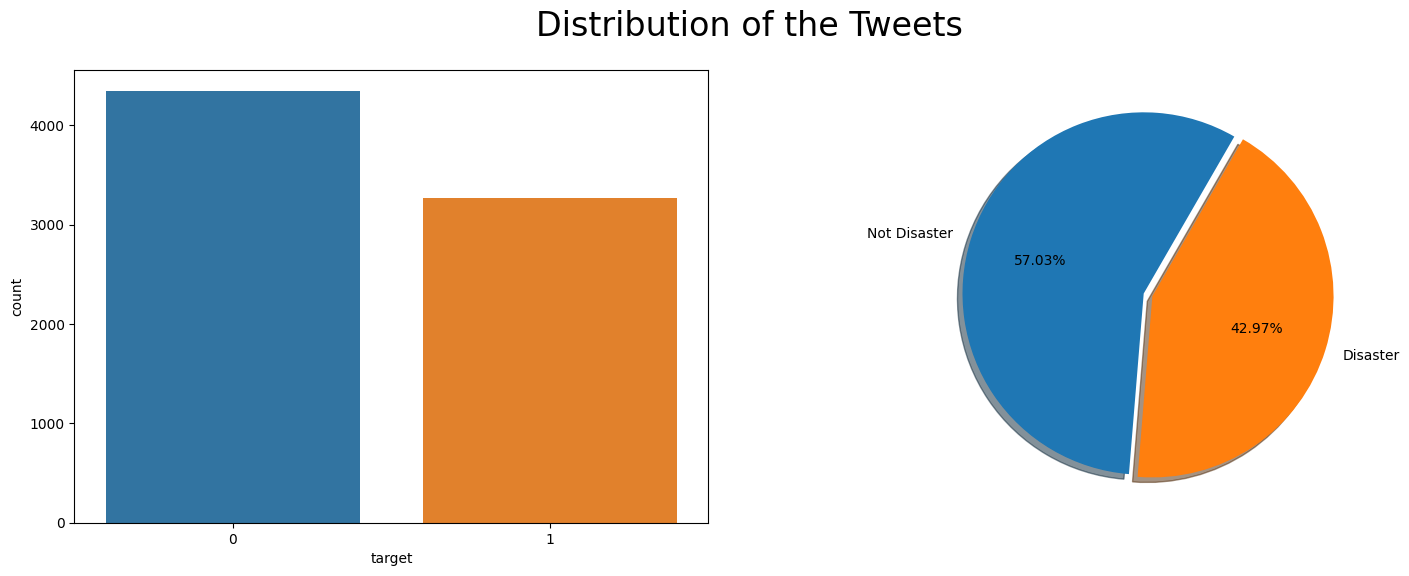

In [ ]:
# Target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(train['target'], ax=axes[0])
axes[1].pie(train['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

### Word cloud for all disaster tweets

In [ ]:
import nltk
stopwords = nltk.corpus.stopwords.words('english')

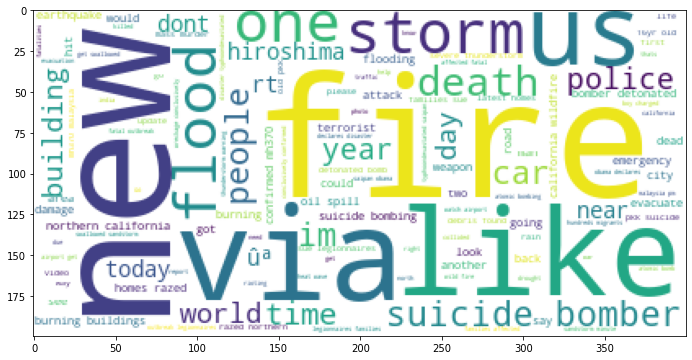

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize=(12,6))
text = ' '.join(train.no_stopwords[train['target']==1])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

### Word cloud for all disaster tweets

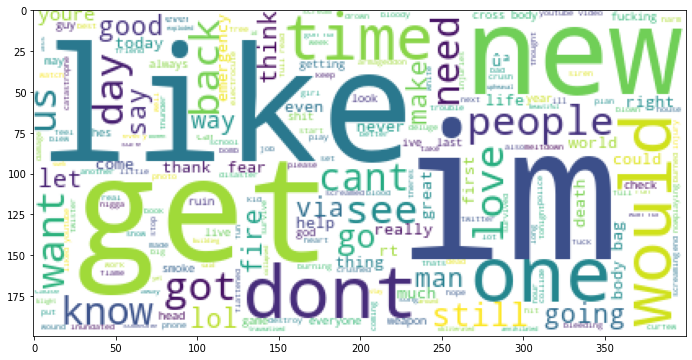

In [ ]:
from wordcloud import WordCloud
plt.figure(figsize=(12,6))
text = ' '.join(train.no_stopwords[train['target']==0])
wc = WordCloud(background_color='white',stopwords=stopwords).generate(text)
plt.imshow(wc)

### Words in a processed tweet

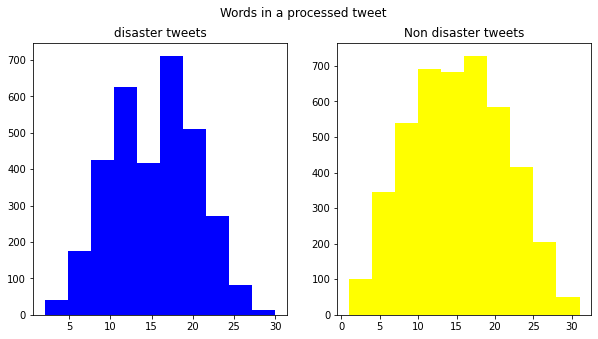

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train[train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='blue')
ax1.set_title('disaster tweets')
tweet_len=train[train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='yellow')
ax2.set_title('Non disaster tweets')
fig.suptitle('Words in a processed tweet')
plt.show()

### Average number of words in a processed tweet

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each processed tweet')

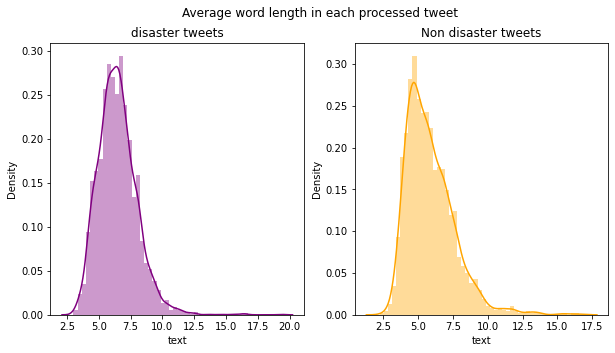

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
word=train[train['target']==1]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='purple')
ax1.set_title('disaster tweets')
word=train[train['target']==0]['text'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='orange')
ax2.set_title('Non disaster tweets')
fig.suptitle('Average word length in each processed tweet')

### Creating embedding of our tweets using GloVe embeddings

In [ ]:
import requests
URL = "https://ia903006.us.archive.org/1/items/glove.6B.50d-300d/glove.6B.100d.txt"
response = requests.get(URL)
open("glove.6B.100d.txt", "wb").write(response.content)


347116733

In [ ]:
# Load pretrained GloVe embeddings
#
embeddings_index = dict()
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
#Creating Embeddings for the tweets

max_len_tweet = 50

tok = Tokenizer()
tok.fit_on_texts(combined)
vocab_size = len(tok.word_index) + 1
encoded_tweet = tok.texts_to_sequences(combined)
padded_tweet = pad_sequences(encoded_tweet, maxlen=max_len_tweet, padding='post')

vocab_size = len(tok.word_index) + 1

tweet_embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tok.word_index.items():
    t_embedding_vector = embeddings_index.get(word)
    if t_embedding_vector is not None:
        tweet_embedding_matrix[i] = t_embedding_vector

In [ ]:
padded_tweet_train=padded_tweet[:int(7613*0.8)]
padded_tweet_test=padded_tweet[int(7613*0.8):7613]
padded_tweet_train_lable=train['target'].values[:int(7613*0.8)]
padded_tweet_test_lable=train['target'].values[int(7613*0.8):]


### Define LSTM network

In [ ]:

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len_tweet, embeddings_initializer=Constant(tweet_embedding_matrix), trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.3, recurrent_dropout=0.2))
model.add(BatchNormalization())
# model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
# model.add(BatchNormalization())
# model.add(LSTM(20,dropout=0.2, recurrent_dropout=0.2))
# model.add(Dropout(0.3))
#model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
optimzer=Adam(learning_rate=1e-4)
model.compile(loss='binary_crossentropy', optimizer=optimzer, metrics=['accuracy', 'mae'])

In [ ]:
model.fit(padded_tweet_train, padded_tweet_train_lable, epochs = 11)

Epoch 1/11
191/191 [==============================] - 28s 128ms/step - loss: 0.5864 - accuracy: 0.7074 - mae: 0.4029
Epoch 2/11
191/191 [==============================] - 25s 129ms/step - loss: 0.5055 - accuracy: 0.7673 - mae: 0.3290
Epoch 3/11
191/191 [==============================] - 25s 129ms/step - loss: 0.4991 - accuracy: 0.7696 - mae: 0.3255
Epoch 4/11
191/191 [==============================] - 25s 130ms/step - loss: 0.4828 - accuracy: 0.7865 - mae: 0.3104
Epoch 5/11
191/191 [==============================] - 25s 129ms/step - loss: 0.4808 - accuracy: 0.7818 - mae: 0.3125
Epoch 6/11
191/191 [==============================] - 25s 129ms/step - loss: 0.4851 - accuracy: 0.7778 - mae: 0.3130
Epoch 7/11
191/191 [==============================] - 25s 130ms/step - loss: 0.4754 - accuracy: 0.7842 - mae: 0.3090
Epoch 8/11
191/191 [==============================] - 25s 130ms/step - loss: 0.4771 - accuracy: 0.7829 - mae: 0.3046
Epoch 9/11
191/191 [==============================] - 25s 129ms/

In [ ]:
preds = model.predict(padded_tweet_test)

In [ ]:
# pred=[1 if i>0.5 else 0 for i in preds]
pred = np.round(preds).astype(int).reshape(7613-int(7613*0.8))

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Not Disaster', 'Disaster']
print(classification_report(padded_tweet_test_lable, pred, target_names=target_names))

              precision    recall  f1-score   support

Not Disaster       0.81      0.84      0.83       814
    Disaster       0.81      0.78      0.79       709

    accuracy                           0.81      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.81      0.81      0.81      1523



### Define LSTM network v2

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len_tweet, embeddings_initializer=Constant(tweet_embedding_matrix), trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model.add(BatchNormalization())
model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.2))
model.add(BatchNormalization())
#model.add(LSTM(20,dropout=0.2, recurrent_dropout=0.2))
#model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
optimzer=Adam()
model.compile(loss='binary_crossentropy', optimizer=optimzer, metrics=['accuracy', 'mae'])

In [ ]:
optimzer.learning_rate#0.001#

In [ ]:
1e-4

In [ ]:
model.fit(padded_tweet_train, padded_tweet_train_lable, epochs = 11)

Epoch 1/11
191/191 [==============================] - 47s 217ms/step - loss: 0.5171 - accuracy: 0.7611 - mae: 0.3343
Epoch 2/11
191/191 [==============================] - 41s 217ms/step - loss: 0.4743 - accuracy: 0.7887 - mae: 0.3046
Epoch 3/11
191/191 [==============================] - 42s 217ms/step - loss: 0.4665 - accuracy: 0.7989 - mae: 0.2952
Epoch 4/11
191/191 [==============================] - 41s 216ms/step - loss: 0.4689 - accuracy: 0.7969 - mae: 0.2974
Epoch 5/11
191/191 [==============================] - 41s 216ms/step - loss: 0.4553 - accuracy: 0.8033 - mae: 0.2893
Epoch 6/11
191/191 [==============================] - 41s 216ms/step - loss: 0.4543 - accuracy: 0.8044 - mae: 0.2854
Epoch 7/11
191/191 [==============================] - 41s 216ms/step - loss: 0.4307 - accuracy: 0.8138 - mae: 0.2721
Epoch 8/11
191/191 [==============================] - 41s 216ms/step - loss: 0.4266 - accuracy: 0.8140 - mae: 0.2696
Epoch 9/11
191/191 [==============================] - 42s 218ms/

In [ ]:
preds = model.predict(padded_tweet_test)

In [ ]:
# pred=[1 if i>0.5 else 0 for i in preds]
pred = np.round(preds).astype(int).reshape(7613-int(7613*0.8))

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Not Disaster', 'Disaster']
print(classification_report(padded_tweet_test_lable, pred, target_names=target_names))

              precision    recall  f1-score   support

Not Disaster       0.81      0.72      0.76       814
    Disaster       0.71      0.81      0.76       709

    accuracy                           0.76      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.76      0.76      1523



### Define LSTM network v3

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len_tweet, embeddings_initializer=Constant(tweet_embedding_matrix), trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(BatchNormalization())
#model.add(LSTM(64, dropout=0.3, recurrent_dropout=0.2))
#model.add(BatchNormalization())
#model.add(LSTM(20,dropout=0.2, recurrent_dropout=0.2))
#model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
optimzer=Adam()
model.compile(loss='binary_crossentropy', optimizer=optimzer, metrics=['accuracy', 'mae'])

In [ ]:
optimzer.learning_rate#0.001#

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [ ]:
model.fit(padded_tweet_train, padded_tweet_train_lable, epochs = 11)

Epoch 1/11
191/191 [==============================] - 29s 131ms/step - loss: 0.5366 - accuracy: 0.7516 - mae: 0.3515
Epoch 2/11
191/191 [==============================] - 25s 132ms/step - loss: 0.5001 - accuracy: 0.7765 - mae: 0.3241
Epoch 3/11
191/191 [==============================] - 25s 131ms/step - loss: 0.4887 - accuracy: 0.7837 - mae: 0.3140
Epoch 4/11
191/191 [==============================] - 25s 131ms/step - loss: 0.4791 - accuracy: 0.7862 - mae: 0.3072
Epoch 5/11
191/191 [==============================] - 25s 131ms/step - loss: 0.4680 - accuracy: 0.7920 - mae: 0.2983
Epoch 6/11
191/191 [==============================] - 25s 131ms/step - loss: 0.4610 - accuracy: 0.7961 - mae: 0.2939
Epoch 7/11
191/191 [==============================] - 25s 131ms/step - loss: 0.4481 - accuracy: 0.8064 - mae: 0.2861
Epoch 8/11
191/191 [==============================] - 25s 132ms/step - loss: 0.4507 - accuracy: 0.7993 - mae: 0.2871
Epoch 9/11
191/191 [==============================] - 25s 132ms/

In [ ]:
preds = model.predict(padded_tweet_test)

In [ ]:
# pred=[1 if i>0.5 else 0 for i in preds]
pred = np.round(preds).astype(int).reshape(7613-int(7613*0.8))

In [ ]:
from sklearn.metrics import classification_report
target_names = ['Not Disaster', 'Disaster']
print(classification_report(padded_tweet_test_lable, pred, target_names=target_names))

              precision    recall  f1-score   support

Not Disaster       0.75      0.94      0.83       814
    Disaster       0.90      0.64      0.75       709

    accuracy                           0.80      1523
   macro avg       0.83      0.79      0.79      1523
weighted avg       0.82      0.80      0.79      1523



# old machine learning

In [ ]:
model_names = [model[0] for model in model_list]
final_scores = {'Model': model_names,
               'Train Score': train_scores,
               'Test Score': test_scores,
               'F1 Score': f1_scores}
final_scores = pd.DataFrame(final_scores)
final_scores['Train Score'] = final_scores['Train Score'].round(3)
final_scores['Test Score'] = final_scores['Test Score'].round(3)
final_scores['F1 Score'] = final_scores['F1 Score'].round(3)
final_scores

,Model,Train Score,Test Score,F1 Score
0,Logistic Regression,0.857,0.796,0.739
1,Decision Tree,0.975,0.729,0.662
2,Support Vector Machine,0.909,0.795,0.729
3,Multinomial Naive Bayes Model,0.816,0.791,0.736
4,Random Forest Classifier,0.974,0.743,0.685
